# Preprocessing - IEMOCAP
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

This notebook implements the preprocessing steps on the IEMOCAP dataset.
- This dataset is used for training, validating, and testing the model.
- Only audio speech samples of the dataset (in "IEMOCAP/(Session Number)/sentences/wav/(Turn Number)") are considered.
- GPU is not used.

The sections are as follows -
- [Dataset](#dataset)
- [Load Files](#load_files)
- [Imports](#imports)
- [Data Extraction](#data_extraction)
- [Audio Preprocessing](#audio_preprocessing)
- [Data Split (Training and Test)](#split_train_test)
- [Audio Augmentation](#audio_augmentation)
- [Conversion to Spectrogram](#conversion_to_spectrogram)
- [Spectrogram Augmentation](#spectrogram_augmentation)
- [Data Split (Training and Validation)](#split_train_valid)
- [Save Files](#save_files)

<a id='dataset'></a>
## Dataset
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

The Interactive Emotional Dyadic Motion Capture (IEMOCAP) database is an acted, multimodal, and multi-speaker database.

- It contains approximately 12 hours of audiovisual data - including video, speech, motion capture of face, text transcriptions. 
- It consists of dyadic sessions where actors perform improvisations or scripted scenarios, specifically selected to elicit emotional expressions.
- The database is annotated by multiple annotators.

| Information | Description |
| :-- | :-: |
| **Type** | Semi-natural |
| **Features** | 10 emotions<br>3 dimensions<br>5 minutes average length<br>1150 samples<br>10 speakers (5 male and 5 female) |
| **Emotions** | Anger<br>Disgust<br>Excited<br>Fear<br>Frustration<br>Happiness<br>Neutral<br>Other<br>Sadness<br>Surprise |
| **Dimensions** | Valence<br>Activation<br>Dominance 

<a id='load_files'></a>
## Load Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Loading the IEMOCAP dataset, preprocessing module, visualization module, and helper module into the session storage (for use in Colab).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Data.zip' 'IEMOCAP Data.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/preprocessing.zip' 'preprocessing.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/visualization.zip' 'visualization.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/helper.zip' 'helper.zip'

!unzip 'IEMOCAP Data.zip'
!unzip 'preprocessing.zip'
!unzip 'visualization.zip'
!unzip 'helper.zip'

<a id='imports'></a>
## Imports
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Importing the required functions from the preprocessing module.
> `split` - code for splitting dataset into required subsets.
<br>
> `multiprocessing` - code for implementing multiprocessing tasks.
<br>
> `iemocap` - code for specific functions on the IEMOCAP dataset.

In [ ]:
import sys
sys.path.append('./preprocessing')

from preprocessing.split import stratified_test_split, stratified_valid_split, make_k_folds, create_subsets
from preprocessing.multiprocessing import multi_audio_aug, multi_audio_to_spec, multi_spec_aug
from preprocessing.iemocap import extract_information, extract_labels, validate_labels
from preprocessing.iemocap import load_audio_files, split_audio_files, drop_audio_samples

#### Step 2:
Importing the required functions from the visualization module.
> `exploration` - code for conducting exploratory visualizations.

In [ ]:
sys.path.append('./visualization')

from visualization.exploration import plot_iemocap_distributions, plot_numerical_values, plot_audio, plot_spectrogram_aug
from visualization.exploration import plot_trimmed_audio, plot_duration, plot_split, plot_audio_aug, plot_spectrogram

#### Step 3:
- Importing the required functions from the helper module.
  > `common` - code for general-purpose functions common among all modules.<br>
  > `preprocessing` - code for general-purpose functions of preprocessing module.<br>
> `visualization` - code for general-purpose functions of visualization module.

- Importing additional libraries.

In [ ]:
sys.path.append('./helper')

from helper.common import save_data
from helper.preprocessing import trim_audio_files, compute_audio_length, class_to_int, drop_labels, create_dir
from helper.preprocessing import divide_audio_data, get_numerical_stats, numerical_scaler
from helper.visualization import get_dataframe, show_dataframe 

import os
import gc

<a id='data_extraction'></a>
## Data Extraction
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Defining the root directory, dataset name, and class labels.

In [ ]:
root = './IEMOCAP Spectrograms'
name = 'iemocap'

class_labels = ['Anger', 'Disgust', 'Excited', 'Fear', 'Frustration', 'Happiness', 'Neutral', 'Other', 'Sadness', 'Surprise']

#### Step 2:
- Extracting the details **[transcription]** and file names.
> Files with no duration stamp or with names including 'X' are not considered as they do not have corresponding utterance files.

- Extracting the labels **[categorical = emotion and gender, numerical = valence, activation, and dominance]**.
> Emotion is the label with the highest frequency among the annotations for the file. If none is highest, first annotation is taken. Gender is extracted from file name. Valence, activation, and dominance are averaged among all annotations for the file with values rounded to 1 decimal place.

- Validation of the extracted labels by checking if emotion lies in `class_labels`, gender in **['Male', 'Female']**, and numerical values lie in **[1, 6]** interval.

In [ ]:
detail_data, files = extract_information()
label_data = extract_labels()
validate_labels(label_data, class_labels)

All labels and values are valid.


#### Step 3:
Displaying `label_data` and `detail_data`.

In [ ]:
label_df = get_dataframe(label_data, name, 'label')
detail_df = get_dataframe(detail_data, name, 'detail')

print(f'Number of Samples: {len(files)}\n')
show_dataframe(label_df, 'label', num_rows = 5)
show_dataframe(detail_df, 'detail', num_rows = 5)

Number of Samples: 10039


-------------Label Data-------------


File Name  Emotion  Gender  Valence  Activation  Dominance
0  Ses01F_impro06_F000  Sadness  Female      3.0         1.7        2.7
1  Ses01F_impro06_F001  Neutral  Female      2.3         2.0        2.3
2  Ses01F_impro06_F002  Sadness  Female      2.0         1.3        2.3
3  Ses01F_impro06_F003  Neutral  Female      3.0         1.7        2.3
4  Ses01F_impro06_F004  Neutral  Female      3.0         1.7        2.7


-------------Detail Data-------------


File Name                                      Transcription
0  Ses01F_impro06_M000                                    I'm sorry, Joy.
1  Ses01F_impro06_F000                                         It's okay.
2  Ses01F_impro06_M001  Is there anything I can get you?  Do you want ...
3  Ses01F_impro06_F001                                        No, no, no.
4  Ses01F_impro06_M002                               ...pick up anything?

#### Step 4:
Plotting label distributions of samples.

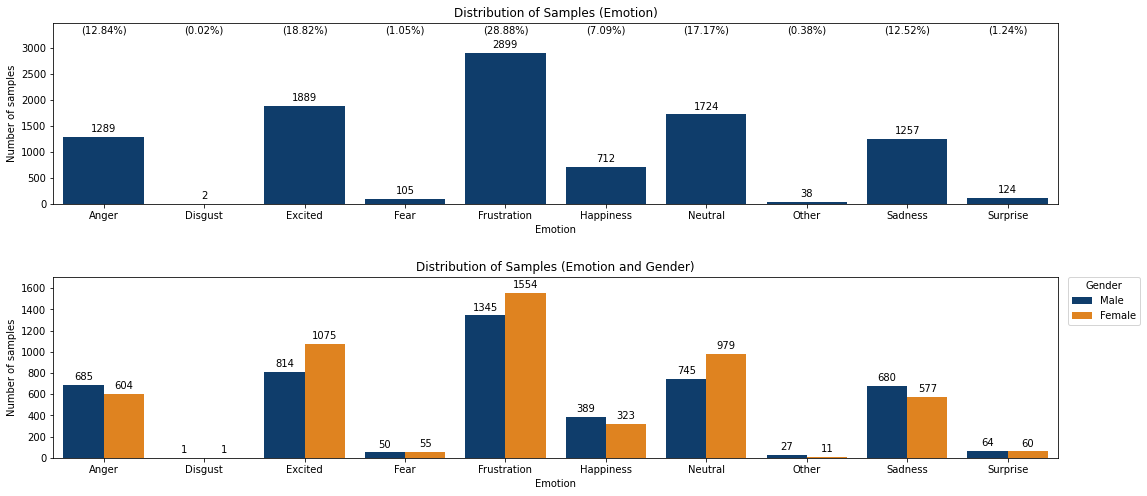

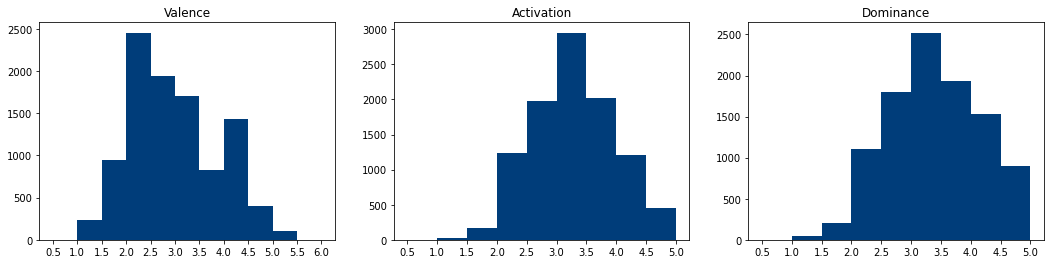

In [ ]:
plot_iemocap_distributions(label_df, class_labels)

#### Step 5:
- Defining the dropped labels and removing data pertaining to them from `class_labels`, `label_data`, `detail_data`, and `files`.
- Creation of required directories i.e. root, test, train, audio, emotion folders etc.

In [ ]:
to_drop = ['Disgust', 'Other']

drop_labels(class_labels, to_drop, label_data, detail_data, files)
create_dir(root, class_labels, name)

print(f'Number of Samples: {len(files)}\n')

Number of Samples: 9999



#### Step 6:
- Calculating statistics for numerical columns.
- 2 scaling methods are used - 
    > **Min-Max Scaler** - each value is transformed using $\frac{\text{x} \text{ - } \text{min}}{\text{max} \text{ - } \text{min}}$. <br>
    > **Standard Scaler** - each value is transformed using $\frac{\text{x} \text{ - } \text{mean}}{\text{std}}$.
- Plotting transformed numerical labels of samples.

In [ ]:
stats = get_numerical_stats(label_df, ['Valence', 'Activation', 'Dominance'])
scaled_vad = numerical_scaler(label_data, stats)


-------------Scaled Data-------------


File Name  Valence - MM  Valence - Std  Activation - MM  \
0  Ses01F_impro06_F000      0.465116       0.234600            0.175   
1  Ses01F_impro06_F001      0.302326      -0.541469            0.250   
2  Ses01F_impro06_F002      0.232558      -0.874071            0.075   
3  Ses01F_impro06_F003      0.465116       0.234600            0.175   
4  Ses01F_impro06_F004      0.465116       0.234600            0.175   

   Activation - Std  Dominance - MM  Dominance - Std  
0         -2.018022           0.425        -0.657019  
1         -1.584907           0.325        -1.177040  
2         -2.595507           0.325        -1.177040  
3         -2.018022           0.325        -1.177040  
4         -2.018022           0.425        -0.657019

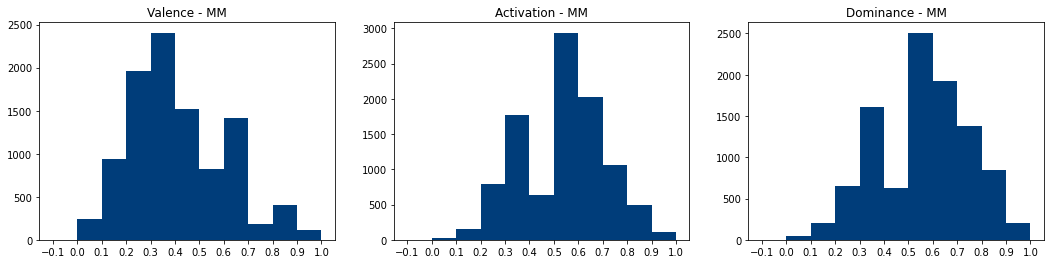

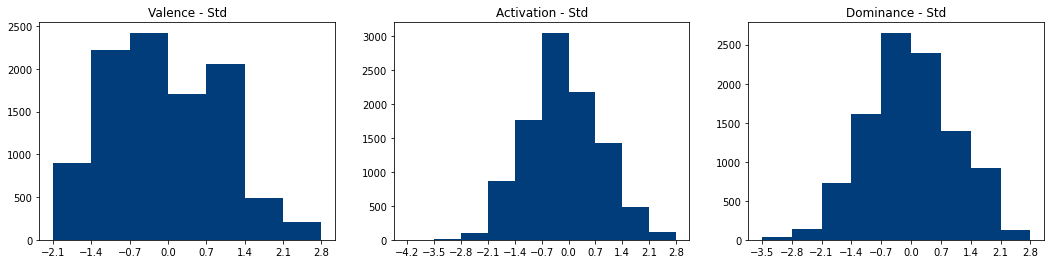

In [ ]:
scaled_df = get_dataframe(scaled_vad, name, 'scaled')
show_dataframe(scaled_df, 'scaled', num_rows = 5)

plot_numerical_values(scaled_df, bin_size = 0.1, columns = ['Valence - MM', 'Activation - MM', 'Dominance - MM'])
plot_numerical_values(scaled_df, bin_size = 0.7, columns = ['Valence - Std', 'Activation - Std', 'Dominance - Std'])

#### Step 7:
- Loading the audio files from the IEMOCAP dataset (sample rate and time-series of amplitude).

- Plotting the audio waveforms.
    > `label` - label of audio.<br>
    > `num_samples` - number of samples to plot.<br>
    > `playable` - if playable audio should be displayed.

In [ ]:
audio_data = load_audio_files(files)

1: Ses03M_impro05a_M012 | Anger | Male


2: Ses03F_script03_2_F019 | Anger | Female


3: Ses01M_script01_1_M034 | Anger | Male


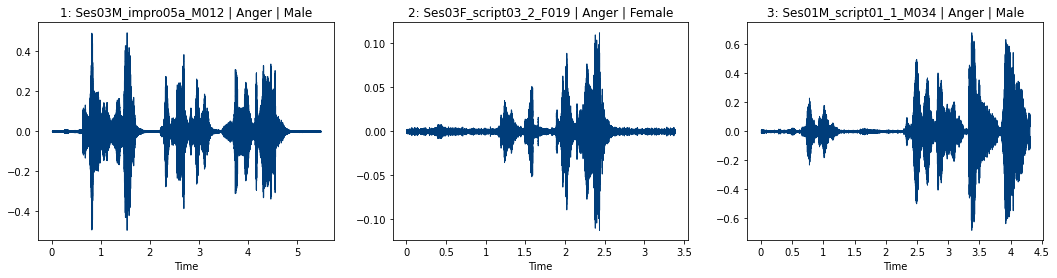

In [ ]:
plot_audio(label_df, audio_data, name, label = 'Anger', num_samples = 3, playable = True)

<a id='audio_preprocessing'></a>
## Audio Preprocessing
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Splitting the audio samples. This ensures that all utterances are of similar duration. The `audio_data`, `label_data`, `detail_data`, and `scaled_vad` are modified.
> Maximum duration of each audio is **3 seconds**. Labels and details of new samples are those of the original sample.

In [ ]:
audio_data, label_data, detail_data, scaled_vad = split_audio_files(audio_data, label_data, detail_data, scaled_vad, max_duration = 3)

#### Step 2:
- Computing durations of the audio samples and storing them in `detail_data`.
- Trimming the leading and trailing silence.
    > Threshold level below which input is considered as silence is **40 db**.
- Computing durations of the trimmed audio samples and storing them in `detail_data`.

In [ ]:
compute_audio_length(audio_data, detail_data)
trimmed_audio_data = trim_audio_files(audio_data, top_db = 40)
compute_audio_length(trimmed_audio_data, detail_data)

#### Step 3:
Dropping audio samples with duration lesser than the threshold duration.
> Threshold is set to **0.5 second**. This ensures that the range of utterance duration is 0.5 to 3 seconds for most samples. Samples that were originally shorter than 0.5 second are not dropped.

In [ ]:
drop_audio_samples(trimmed_audio_data, label_data, detail_data, scaled_vad, min_duration = 0.5)

#### Step 4:
Plotting the trimmed audio waveforms.
> `num_samples` - number of samples to plot.<br>
> `playable` - if playable audio should be displayed.

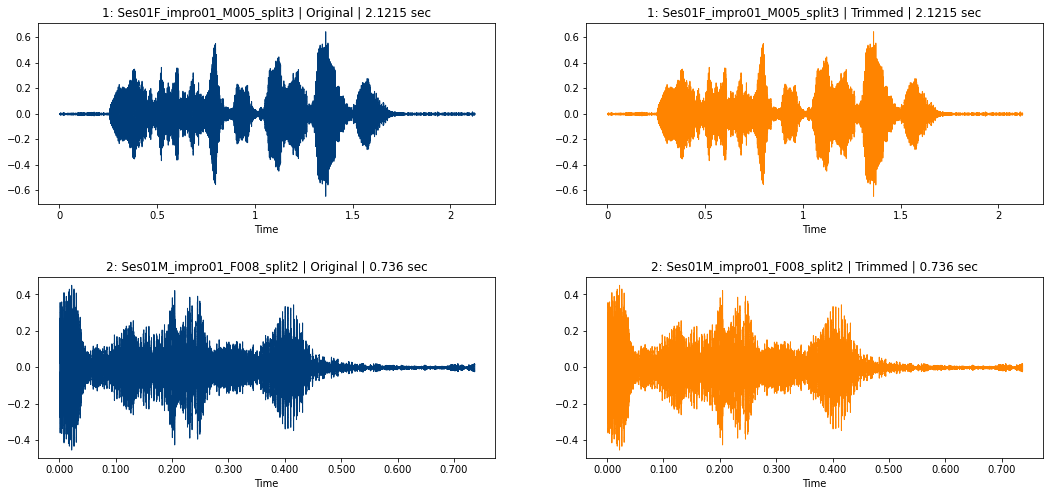

In [ ]:
detail_df = get_dataframe(detail_data, name, 'detail')
plot_trimmed_audio(detail_df, audio_data, trimmed_audio_data, num_samples = 2, playable = False)

#### Step 5:

Plotting the duration distribution of samples.

-------------Original Duration-------------
Maximum: 3.00 sec
Minimum: 0.50 sec
Average: 2.44 sec

-------------Trimmed Duration-------------
Maximum: 3.00 sec
Minimum: 0.50 sec
Average: 2.44 sec


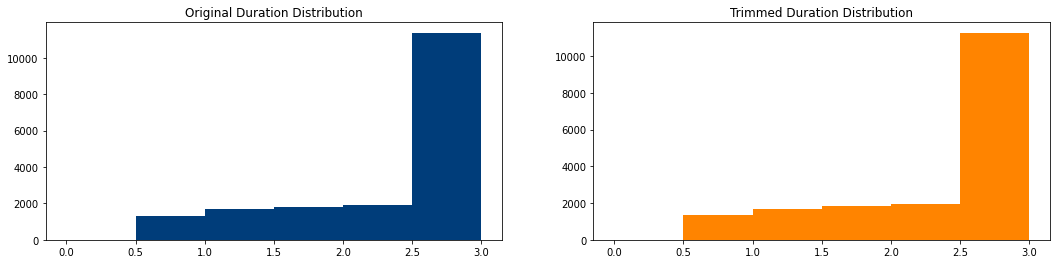

In [ ]:
plot_duration(detail_df, bin_size = 0.5)

<a id='split_train_test'></a>
## Data Split (Training and Test)
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Splitting the dataset into training and test sets.
    > Train set contains **85%** samples and test set contains **15%** samples. Data is shuffled and splitting is stratified i.e. 85% of each emotion is in the train set and 15% of each emotion is in the test set.

- Dividing the audio data based on train and test sets.

In [ ]:
split_data = stratified_test_split(label_data, class_labels, split_ratio = 0.15)
train_audio_data, test_audio_data = divide_audio_data(trimmed_audio_data, split_data)

#### Step 2:
Plotting label distribution across split data.

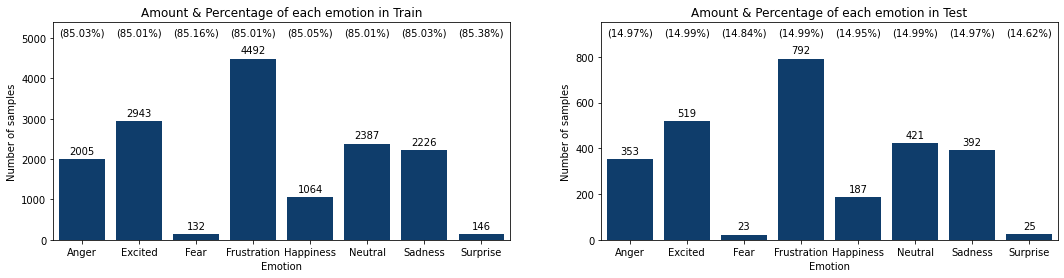

In [ ]:
label_df = get_dataframe(label_data, name, 'label')
plot_split(split_data, label_df, label_data, class_labels)

<a id='audio_augmentation'></a>
## Audio Augmentation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Creating subsets of audio data.
> Subsets are required so that operations are performed on 1 subset at a time due to **memory limitations**. Each subset has a maximum of **1000** original samples.

> `num_train` - number of subsets of train data.<br>
> `num_test` - number of subsets of test data.

In [ ]:
num_train = create_subsets(root, train_audio_data, 'train', size = 1000)
num_test = create_subsets(root, test_audio_data, 'test', size = 1000)

#### Step 2:
Deleting data which will no longer be required to free up memory.

In [ ]:
del audio_data, trimmed_audio_data, train_audio_data, test_audio_data
_ = gc.collect()

#### Step 3:
Defining the audio augmentation. For every audio sample, 3 augmentations are made:
- Addition of white noise (by a factor of **0.075**).
- Time stretch (by a factor of either **0.75 or 1.25**).
- Pitch shift (by a factor of either **-1 or 1 semitones**).

In [ ]:
augment_factors = [0.075, [0.75, 1.25], [-1, 1]]

#### Step 4:
Augmentation of the audio samples in each subset. This involves -
- Loading a subset.
- Augmenting the audio.
- Saving the augmented audio of that subset.

> The augmentation function is assigned to a seperate `process` using the `multiprocessing` module to ensure that resources (mainly RAM) are relinquished when function has finished execution.

In [ ]:
multi_audio_aug(root, 'train', augment_factors, num_train)

IntProgress(value=0, description='Subset - 0 / 16', layout=Layout(width='500px'), max=16, style=ProgressStyle(…

In [ ]:
multi_audio_aug(root, 'test', augment_factors, num_test)

IntProgress(value=0, description='Subset - 0 / 3', layout=Layout(width='500px'), max=3, style=ProgressStyle(de…

#### Step 5:
Plotting the augmented audio waveforms of a random sample.
> `playable` - if playable audio should be displayed.

1: Ses05F_script02_2_M039_split1 | Original


2: Ses05F_script02_2_M039_split1 | Noise Addition


3: Ses05F_script02_2_M039_split1 | Time Stretch


4: Ses05F_script02_2_M039_split1 | Pitch Shift


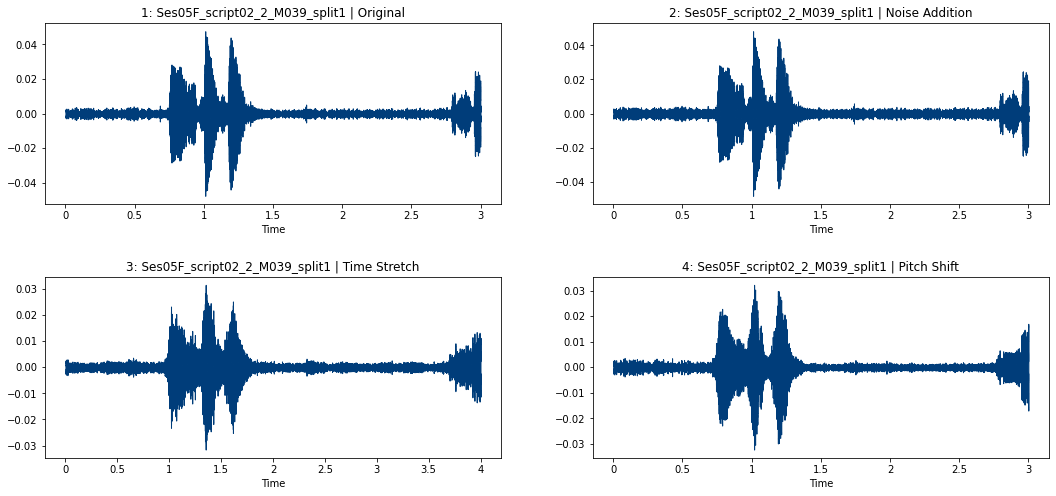

In [ ]:
plot_audio_aug(root, 'train', num_train, playable = True)

1: Ses05F_script03_1_M024_split1 | Original


2: Ses05F_script03_1_M024_split1 | Noise Addition


3: Ses05F_script03_1_M024_split1 | Time Stretch


4: Ses05F_script03_1_M024_split1 | Pitch Shift


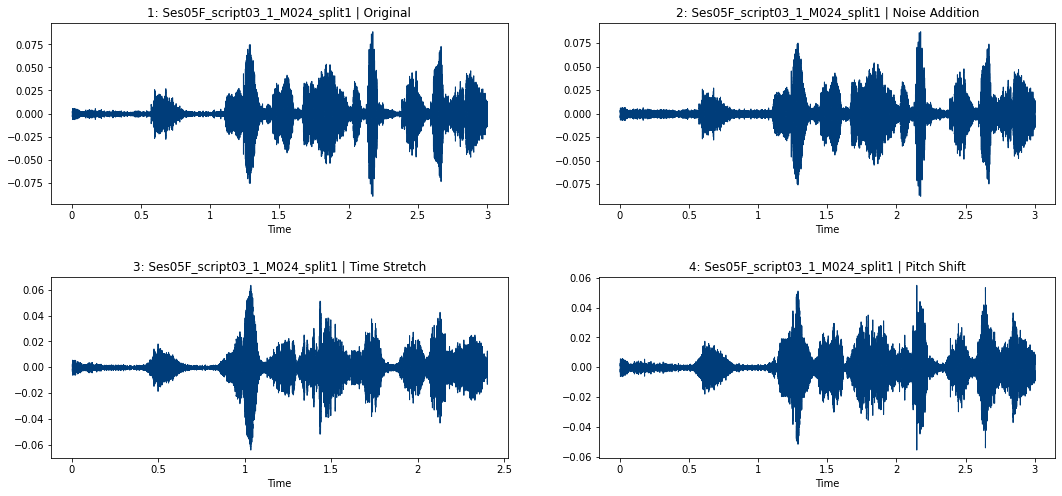

In [ ]:
plot_audio_aug(root, 'test', num_test, playable = True)

<a id='conversion_to_spectrogram'></a>
## Conversion to Spectrogram
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">


#### Overview
- A Log Mel Spectrogram is a visual representation of signal strength at different frequencies over time. 
- It provides a perceptual representation of amplitude (decibels) and frequency (mel scale) i.e., in a non-linear (logarithmic) manner. 
- This is also how our ears distance sounds. Sounds of equal distance from each other on the mel scale are also percieved by humans as being equal in distance from one another.

It is prepared through the following steps - 
- Sample the input with windows of size `n_fft` and make hops of size `hop_length`.
- Compute the Fast Fourier Transform for each window to transform from time domain to frequency domain.
- Separate the frequency spectrum into `n_mels`(bins) with evenly spaced frequencies (non-linear distance). Each bin is transformed into a corresponding bin in the mel scale.
- For each window, take the dot product of the magnitude and the corresponding transformed frequency, to obtain a new scale.

#### Step 1:
Converting audio samples to spectrograms (**256*256** pixels in size). This involves -
- Loading a subset.
- Converting subset samples to spectrograms with 3 (RGB) channels.
- Saving in **png format**.

> Values for spectrogram generation are -<br>
> `n_fft` - 2048.<br>
> `hop_length` - 512.<br>
> `n_mels` - 256.

> The conversion function is assigned to a seperate `process` using the `multiprocessing` module to ensure that resources (mainly RAM) are relinquished when function has finished execution.

In [ ]:
spec_params = [2048, 512, 256]

In [ ]:
multi_audio_to_spec(root, label_data, 'train', spec_params, num_train)

IntProgress(value=0, description='Subset - 0 / 16', layout=Layout(width='500px'), max=16, style=ProgressStyle(…

In [ ]:
multi_audio_to_spec(root, label_data, 'test', spec_params, num_test)

IntProgress(value=0, description='Subset - 0 / 3', layout=Layout(width='500px'), max=3, style=ProgressStyle(de…

#### Step 2:
Plotting a spectrogram of an original audio sample from each label.
> `playable` - if playable audio should be displayed.

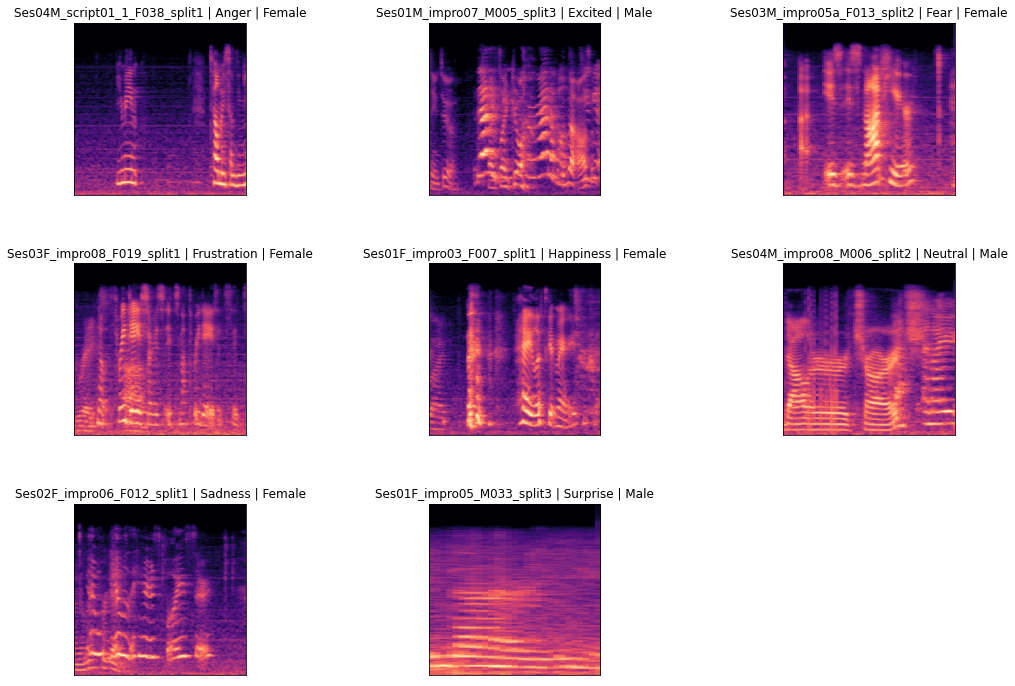

In [ ]:
plot_spectrogram(root, split_data, 'train', label_data, class_labels, name)

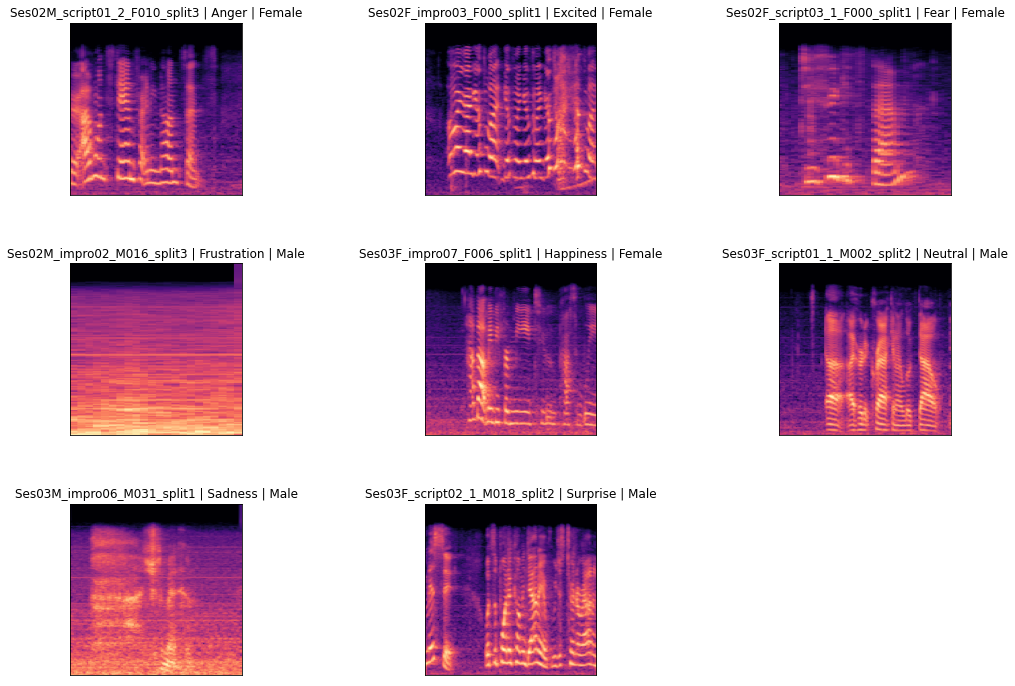

In [ ]:
plot_spectrogram(root, split_data, 'test', label_data, class_labels, name)

<a id='spectrogram_augmentation'></a>
## Spectrogram Augmentation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Defining the spectrogram augmentation. 
> Frequency masking and Time masking (with mask parameter between **10 and 20**) are performed on the spectrogram of each audio sample. 

> Frequency channels $[f_0, f_0 + f)$ are masked.<br>
> - $f$ is chosen from a uniform distribution from **10** to **20** (the frequency mask parameter $F$).<br>
> - $f_0$ is chosen from $(0, ν − f)$ where $ν$ is the number of frequency channels.

> t consecutive time steps $[t_0, t_0 + t)$ are masked.<br>
> - $t$ is chosen from a uniform distribution from **10** to **20** (the frequency mask parameter $T$).<br>
> - $t_0$ is chosen from $(0, \tau − t)$ where $\tau$ is the time steps.

In [ ]:
augment_width = [10, 20]

#### Step 2:
Augmenting the spectrogram images, one subset at a time, and saving in **png format**. This involves - 
- Loading a subset.
- Augmenting the spectrogram.
- Saving in **png format**.

> The augmentation function is assigned to a seperate `process` using the `multiprocessing` module to ensure that resources (mainly RAM) are relinquished when function has finished execution.

In [ ]:
multi_spec_aug(root, label_data, 'train', augment_width, num_train)        

IntProgress(value=0, description='Subset - 0 / 16', layout=Layout(width='500px'), max=16, style=ProgressStyle(…

In [ ]:
multi_spec_aug(root, label_data, 'test', augment_width, num_test)

IntProgress(value=0, description='Subset - 0 / 3', layout=Layout(width='500px'), max=3, style=ProgressStyle(de…

#### Step 3:
Plotting the augmented spectrograms.
> `num_sample` - number of samples to plot.

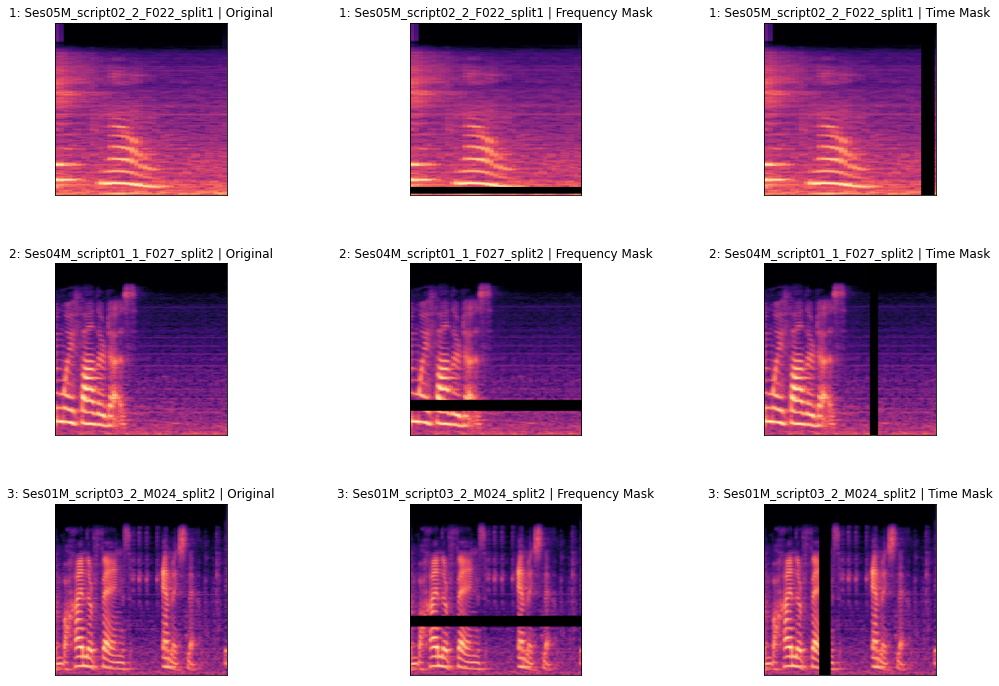

In [ ]:
plot_spectrogram_aug(root, split_data, 'train', label_data, num_samples = 3)

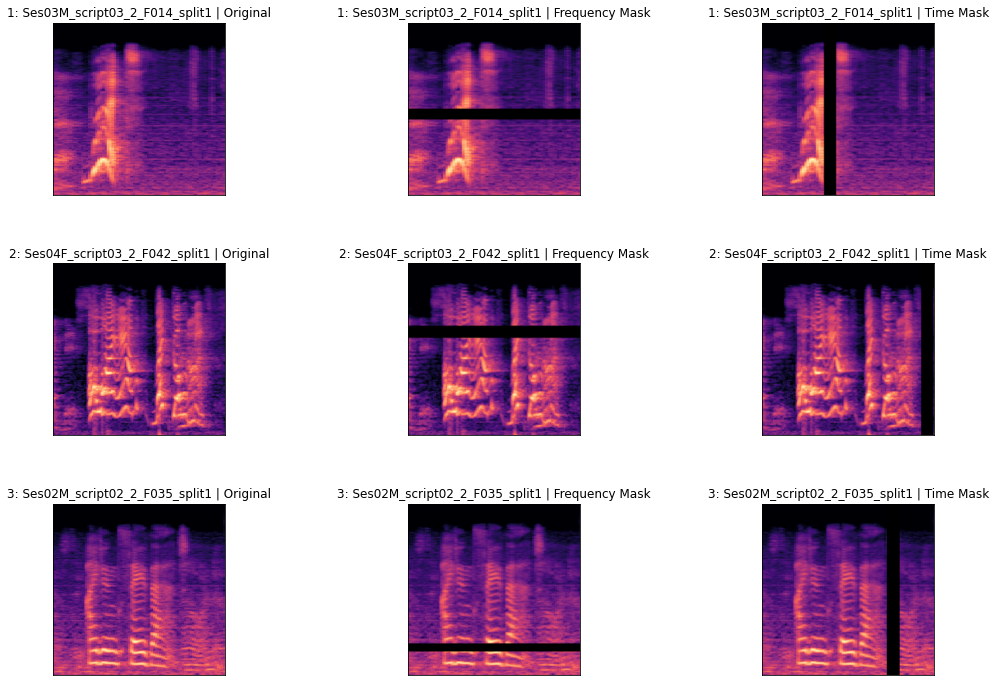

In [ ]:
plot_spectrogram_aug(root, split_data, 'test', label_data, num_samples = 3)

Each audio sample will therefore have **5 augmentations** in total.

<a id='split_train_valid'></a>
## Data Split (Training and Validation)
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Making k folds for cross validation from training set.
> A copy of the training set is split into k folds of data. Data is shuffled and splitting is stratified i.e. $\frac{1}{k}$% of each emotion is in each fold. Percentage is in terms of the **train set**.

> Percentage of data in each set:
> - Train - $\frac{k \text{ - } 1}{k}$% of 85%
> - Valid - $\frac{1}{k}$% of 85% 
> - Test - 15%

> With **k = 5**, percentage of each emotion in a fold is 20% of 85% = **17%**.

In [ ]:
cross_data = make_k_folds(split_data['train'], label_data, class_labels, k = 5)

#### Step 2:
Plotting label distribution across k folds.

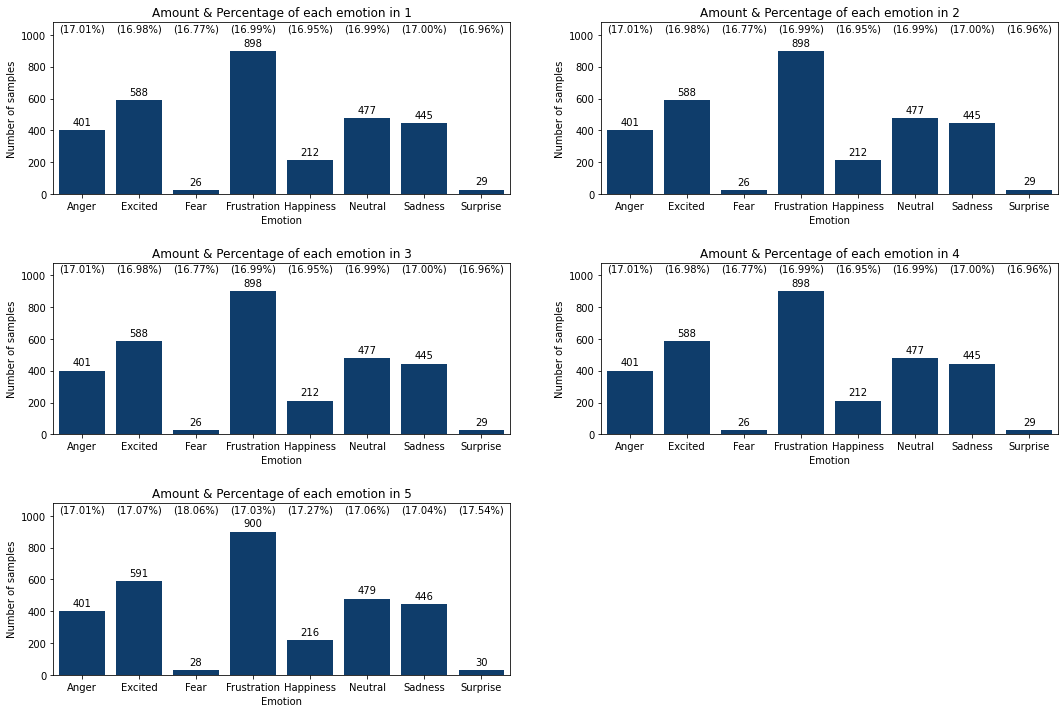

In [ ]:
plot_split(cross_data, label_df, label_data, class_labels)

#### Step 3:
Splitting the original training dataset into training and validation sets.
> Train set contains **70%** samples and valid set contains **15%** samples. Data is shuffled and splitting is stratified i.e. 70% of each emotion is in the train set and 15% of each emotion is in the valid set. Percentages are in terms of the **whole dataset**.

> Percentage of data in each set:
> - Train - 70%
> - Valid - 15%
> - Test - 15%

In [ ]:
split_data['valid'] = stratified_valid_split(split_data['train'], label_data, label_data, class_labels, split_ratio = 0.15)

#### Step 4:
Plotting label distribution across split data.

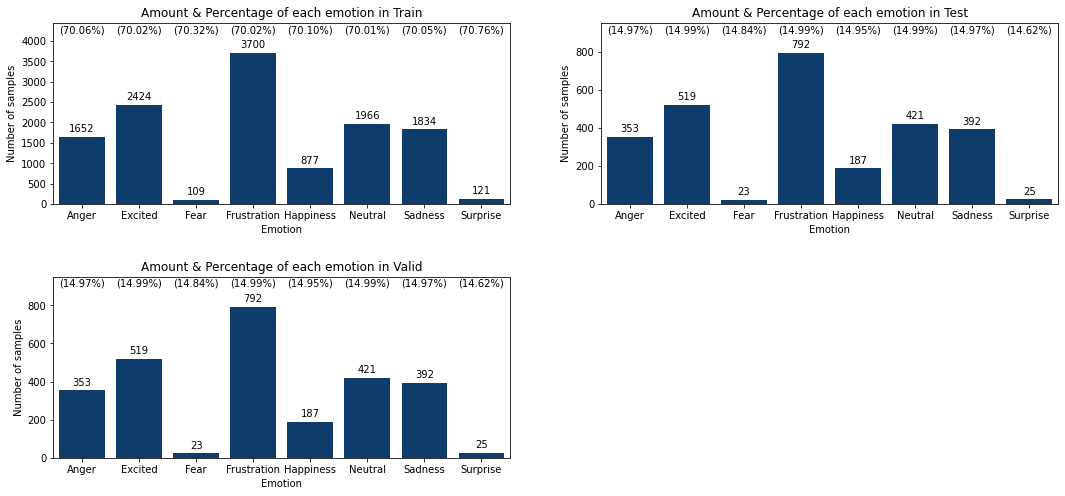

In [ ]:
plot_split(split_data, label_df, label_data, class_labels)

<a id='save_files'></a>
## Save Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Saving the `IEMOCAP Meta` folder and the `IEMOCAP Spectrogram` folder (from Colab session storage). Additionally, removing the `Audio` folder.
> `class_data` - dictionary that maps labels to integers.<br>
> `IEMOCAP Spectrograms` - contains the spectrograms generated in this notebook.<br>
> `IEMOCAP Meta` - contains the metadata generated in this notebook.

In [ ]:
class_data = class_to_int(class_labels, name)

meta_root = './IEMOCAP Meta'
os.mkdir(meta_root)

save_data(meta_root, detail_data, 'Detail')
save_data(meta_root, label_data, 'Label')
save_data(meta_root, split_data, 'Split')
save_data(meta_root, class_data, 'Class')
save_data(meta_root, cross_data, 'Cross')
save_data(meta_root, stats, 'Statistics')
save_data(meta_root, scaled_vad, 'Scaled VAD')

In [ ]:
!rm -rf './IEMOCAP Spectrograms/Audio'
!zip -r '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta'
!zip -r '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Spectrograms.zip' 'IEMOCAP Spectrograms'